# Covid-19 infección en Ecuador. Modelos probabilisticos
Implementacion de un modelo probabilistico de infección por el virus Covid-19

Se realiza un análisis probabilistico simple del crecimiento de la infección en Python y el modelos para comprender mejor la evolución de la infección.

Se crea modelos de series temporales del número total de personas infectadas hasta la fecha (es decir, las personas realmente infectadas más las personas que han sido infectadas). Estos modelos tienen parámetros , que se estimarán por ajuste de probabilidad.

In [145]:
# Importar las librerias para el analasis
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
from sklearn import linear_model
import matplotlib.pyplot as plt
%matplotlib inline


In [146]:
# Actualizar los datos (URL)
url = 'https://covid.ourworldindata.org/data/ecdc/new_cases.csv'
df = pd.read_csv(url)
df

,date,World,Afghanistan,Albania,Algeria,Andorra,Angola,Anguilla,Antigua and Barbuda,Argentina,...,Uzbekistan,Vanuatu,Vatican,Venezuela,Vietnam,Wallis and Futuna,Western Sahara,Yemen,Zambia,Zimbabwe
0,2019-12-31,27,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
1,2020-01-01,0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
2,2020-01-02,0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
3,2020-01-03,17,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
4,2020-01-04,0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,2020-11-12,623536,146.0,507.0,811.0,90.0,136.0,0.0,0.0,10880.0,...,224.0,0.0,0.0,0.0,26.0,0.0,0.0,0.0,39.0,57.0
318,2020-11-13,646171,360.0,410.0,851.0,49.0,137.0,0.0,0.0,11162.0,...,220.0,0.0,0.0,695.0,1.0,0.0,0.0,0.0,0.0,29.0
319,2020-11-14,628489,66.0,490.0,867.0,109.0,104.0,0.0,2.0,11859.0,...,63.0,0.0,0.0,0.0,3.0,0.0,0.0,2.0,57.0,69.0
320,2020-11-15,589885,205.0,532.0,844.0,0.0,171.0,0.0,1.0,8468.0,...,0.0,0.0,0.0,301.0,9.0,0.0,0.0,0.0,4.0,21.0


Imprimos los resultados y agregamos el numero del dia


In [147]:
df = df.loc[:,['date','Ecuador']] #Selecciono las columnas de analasis
# Expresar las fechas en numero de dias desde el 01 Enero
FMT = '%Y-%m-%d'
date = df['date']
df['date'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-01-01", FMT)).days)
df

,date,Ecuador
0,-1,0.0
1,0,0.0
2,1,0.0
3,2,0.0
4,3,0.0
...,...,...
317,316,919.0
318,317,883.0
319,318,1161.0
320,319,953.0


<AxesSubplot:xlabel='date'>

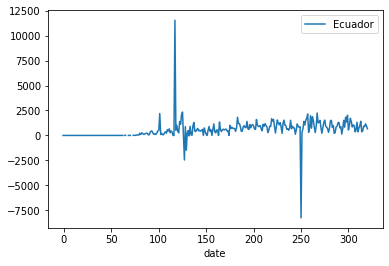

In [148]:
df.plot(x ='date', y='Ecuador')

Ahora podemos analizar un modelo probabilisto para el examen.

## El modelo basado en probabilidad

Para realizar un estimacion del factor de crecimiento de los casos de Covid 19 en Ecuador calculamos la mediana, con esto obtenemo el valor medio de crecimiento de un conjunto de datos, con esto podemos obtener un factor de crecimiento o taza de crecimiento de los nuevos casos.



In [149]:
filtro = df["Ecuador"][61:] # Filtro los datos que se empezo a tener casos
#Obtenemos la mediana
media = filtro.mean()
mediana = filtro.median()
print(mediana)
print(media)

666.5
704.27734375


De la ecuación de la recta y = mX + b nuestra pendiente «m» es el coeficiente y el término independiente «b»


In [151]:
#Vamos a comprobar:
# según la media y la mediana podemos obtener la taza de crecieminto y predicir su comportamiento.
# Cargamos los datos de total de casos
url = 'https://covid.ourworldindata.org/data/ecdc/total_cases.csv'
df_t = pd.read_csv(url)
FMT = '%Y-%m-%d'
date = df_t['date']
df_t['date'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-01-01", FMT)).days)
df_t = df_t.loc[:,['date','Ecuador']] #Selecciono las columnas de analisis
y = list(df_t.iloc [:, 1]) # Total casos
x = list(df_t.iloc [:, 0]) # Dias
#Realizamos un ejemplo de prediccion
prediccion_siguiente = int(y[-1] + mediana)
print(prediccion_siguiente)

180961


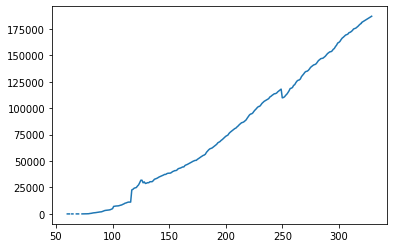

In [152]:
# Quiero predecir cuántos "Casos" voy a obtener de aqui a 10 dias.
for i in range(x[-1], x[-1]+10):
    x.append(i)
    y.append(int(y[-1] + mediana))
plt.plot(x[61:], y[61:])
plt.show()

# Practica

1. Comparar el modelo de predicción matemático vs probabilidad.

           4           3         2
2.792e-05 x - 0.01695 x + 4.623 x + 185.4 x - 3227


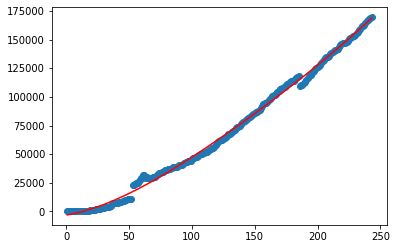

In [108]:
# MODELO POLINOMIAL
%matplotlib inline  
from pylab import *  
import numpy as np
import pandas as pd
import sympy as sp

df = pd.read_csv('owid-covid-data.csv').fillna(0) # poniendo datos nan a cero
ndf= df.loc[(df['location'] == 'Ecuador') & (df['total_cases'] != 0)] # filtrando por pais y no ceros 
ndf1=ndf[['date','total_cases']]
x=np.arange(1,len(ndf1)+1,1, dtype='float') # arreglo de x lo creo para simular el numero del dia y el numero de casos
y=np.array(ndf1.values[:,1], dtype='float')

crx=x
cry=y
#Numero de Casos
fun1 = np.poly1d(np.polyfit(x, y, 4))
print(fun1)
y_pred=fun1(x)
plt.scatter(x, y)
plt.plot(x, y_pred, c='r')  
plt.show()

In [109]:
# METODO PROBABILISTICO
media = ndf1.values[:,1].mean()
mediana = np.median(ndf1.values[:,1])
print("MEDIA: ",media)
print("MEDIANA: ",mediana)

MEDIA:  69294.50617283951
MEDIANA:  61535.0


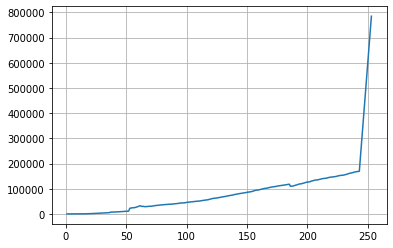

In [110]:
for it in range(int(x[-1]), int(x[-1]+10)):
    x=np.append(x,(it+1))
    y=np.append(y,y[-1] + mediana)
plt.plot(x,y)
plt.grid(True)
plt.show()

In [111]:
y_pred=np.array([])
y_pred=fun1(x)
print ('{3}{0:8}{3} {3}{1:12}{3} {3}{2:10}{3}'.format("-------","------------","----------","|"))
print ('{3}{0:8}{3} {3}{1:12}{3} {3}{2:10}{3}'.format("--Día--","Probalistico","Polinomial","|"))
print ('{3}{0:8}{3} {3}{1:12}{3} {3}{2:10}{3}'.format("-------","------------","----------","|"))
for i,j,k in zip(x,y,y_pred):
    print ('{3}{0:8}{3} {3}{1:12}{3} {3}{2:10}{3}'.format(i, j,round(k,2),"|"))
print ('{3}{0:8}{3} {3}{1:12}{3} {3}{2:10}{3}'.format("-------","------------","----------","|"))

|------- | |------------| |----------|
|--Día-- | |Probalistico| |Polinomial|
|------- | |------------| |----------|
|     1.0| |         1.0| |  -3036.72|
|     2.0| |         6.0| |  -2837.62|
|     3.0| |         7.0| |  -2629.47|
|     4.0| |        10.0| |  -2412.38|
|     5.0| |        13.0| |  -2186.44|
|     6.0| |        14.0| |  -1951.76|
|     7.0| |        15.0| |  -1708.43|
|     8.0| |        17.0| |  -1456.55|
|     9.0| |        23.0| |  -1196.22|
|    10.0| |        28.0| |   -927.53|
|    11.0| |        37.0| |   -650.57|
|    12.0| |        58.0| |   -365.46|
|    13.0| |       111.0| |    -72.26|
|    14.0| |       168.0| |    228.91|
|    15.0| |       199.0| |    537.97|
|    16.0| |       426.0| |    854.82|
|    17.0| |       532.0| |   1179.38|
|    18.0| |       789.0| |   1511.55|
|    19.0| |       981.0| |   1851.25|
|    20.0| |      1082.0| |   2198.37|
|    21.0| |      1211.0| |   2552.85|
|    22.0| |      1403.0| |   2914.58|
|    23.0| |      1627.0|

2. Retroceder un semana y comparar el modelo matemático vs probabilidad vs reales. Solo cargan los datos para generar los modelos menos 7 dias.

In [112]:
# Datos con una semana atrás
sem_x=np.arange(1,(len(ndf1)+1)-7,1, dtype='float')
sem_y=np.array(ndf1.values[:len(ndf1)-7,1], dtype='float')

print ('{4}{0:8}{4} {4}{1:8}{4} {4}{2:12}{4} {4}{3:10}{4}'.format("-------","--------","------------","----------","|"))
print ('{4}{0:8}{4} {4}{1:8}{4} {4}{2:12}{4} {4}{3:10}{4}'.format("--Día--","-Reales-","Probalistico","Polinomial","|"))
print ('{4}{0:8}{4} {4}{1:8}{4} {4}{2:12}{4} {4}{3:10}{4}'.format("-------","--------","------------","----------","|"))
for i,j,k in zip(sem_x,sem_y,y_pred):
    print ('{4}{0:8}{4} {4}{1:8}{4} {4}{2:12}{4} {4}{3:10}{4}'.format(i, j, j,round(k,2),"|"))
print ('{4}{0:8}{4} {4}{1:8}{4} {4}{2:12}{4} {4}{3:10}{4}'.format("-------","--------","------------","----------","|"))

|------- | |--------| |------------| |----------|
|--Día-- | |-Reales-| |Probalistico| |Polinomial|
|------- | |--------| |------------| |----------|
|     1.0| |     1.0| |         1.0| |  -3036.72|
|     2.0| |     6.0| |         6.0| |  -2837.62|
|     3.0| |     7.0| |         7.0| |  -2629.47|
|     4.0| |    10.0| |        10.0| |  -2412.38|
|     5.0| |    13.0| |        13.0| |  -2186.44|
|     6.0| |    14.0| |        14.0| |  -1951.76|
|     7.0| |    15.0| |        15.0| |  -1708.43|
|     8.0| |    17.0| |        17.0| |  -1456.55|
|     9.0| |    23.0| |        23.0| |  -1196.22|
|    10.0| |    28.0| |        28.0| |   -927.53|
|    11.0| |    37.0| |        37.0| |   -650.57|
|    12.0| |    58.0| |        58.0| |   -365.46|
|    13.0| |   111.0| |       111.0| |    -72.26|
|    14.0| |   168.0| |       168.0| |    228.91|
|    15.0| |   199.0| |       199.0| |    537.97|
|    16.0| |   426.0| |       426.0| |    854.82|
|    17.0| |   532.0| |       532.0| |   1179.38|


Puntos extras: Investiga sobre la correlacion de variables y aplicar el calculo en base a los datos del Ecuador.

# Correlación entre variables
La Correlación es una técnica estadística usada para determinar la relación entre
dos o más variables.

La relación entre la duración de una carrera de distancia y el test del escalón, o la relación entre las características de la personalidad y la participación en deportes de alto riesgo.La correlación puede ser de al menos dos variables o de una variable dependiente y dos o más variables independientes, denominada correlación múltiple.

## Coeficiente de correlación
El Coeficiente de Correlación es un valor cuantitativo de la relación entre dos o
más variables.

La coeficiente de correlación puede variar desde -1.00 hasta 1.00.
La correlación de proporcionalidad directa o positiva se establece con los valores +1.00 y de proporcionalidad inversa o negativa, con -1.00. No existe relación entre las variables cuando el coeficiente es de 0.00. 

$ r =\frac{N\sum{XY} -(\sum{X})(\sum{Y})}{\sqrt{N \sum{X^2}- (\sum{X})^2} * \sqrt{N \sum{Y^2}- (\sum{Y})^2}}$

In [156]:
xx=crx**2
yy=cry**2
xy=crx*cry
r=(len(crx)*sum(xy)-(sum(crx)*sum(cry)))/(sqrt(len(crx)*sum(xx)-(sum(crx)**2))*sqrt(len(crx)*sum(yy)-(sum(cry)**2)))
print("El coeficiente de correlación de los casos de Covid en Ecuador es: ",r)

El coeficiente de correlación de los casos de Covid en Ecuador es:  0.9922453405398545


## Analisis

Al analizar los datos se nota que el modelo probabilistico no es muy adecuado para este caso de problemas debido a los grandes saltos que dan los valores en la vida real. Mientras que el modelo polinomial tiene un error muy bajo comparado con el probabistico

## Conclusiones

## Criterio personal (politico, economico y  social de la situacion)



# Referencias

- https://www.researchgate.net/publication/340092755_Infeccion_del_Covid-19_en_Colombia_Una_comparacion_de_modelos_logisticos_y_exponenciales_aplicados_a_la_infeccion_por_el_virus_en_Colombia

- https://www.aprendemachinelearning.com/regresion-lineal-en-espanol-con-python/